## This is project is to predict the wellhead pressure and flow pattern within the well

![shale well](img/shallwellimg.jpg)

### Import modules

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

%matplotlib inline

### Read raw data

In [20]:
df=pd.read_csv('simple_well2.csv')
dfnoise=pd.read_csv('simple_well_noise3.csv')

In [21]:
df.head()

,Date,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FlowPatternGasLiquid6,FINAPRESS,FINATEMP
0,1/1/2020,1.990,439.6,4429.671236,5646.8,0.082286,0.809676,0.838839,403668.6203,0.522158,2.567768,0.013021,0.273833,4,2175.632949,212.158344
1,1/2/2020,1.979,429.6,3954.486042,5594.4,0.083133,0.732753,0.824077,369734.8323,0.527079,2.323320,0.012940,0.275160,4,2187.198066,210.639192
2,1/3/2020,1.969,419.9,3554.119221,5542.8,0.083925,0.667531,0.809393,341074.8608,0.531691,2.116113,0.012864,0.276514,4,2197.358736,209.096588
3,1/4/2020,1.959,410.6,3213.437317,5491.9,0.084655,0.611674,0.794856,316619.2477,0.535965,1.938724,0.012791,0.277891,4,2206.134095,207.534762
4,1/5/2020,1.949,401.6,2920.977411,5441.7,0.085334,0.563410,0.780499,295569.5475,0.539954,1.785498,0.012722,0.279288,4,2213.688390,205.957465


In [22]:
df.drop(columns='Date', inplace=True)

In [23]:
dfnoise.drop(columns='Date', inplace=True)

In [24]:
df.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FlowPatternGasLiquid6,FINAPRESS,FINATEMP
0,1.990,439.6,4429.671236,5646.8,0.082286,0.809676,0.838839,403668.6203,0.522158,2.567768,0.013021,0.273833,4,2175.632949,212.158344
1,1.979,429.6,3954.486042,5594.4,0.083133,0.732753,0.824077,369734.8323,0.527079,2.323320,0.012940,0.275160,4,2187.198066,210.639192
2,1.969,419.9,3554.119221,5542.8,0.083925,0.667531,0.809393,341074.8608,0.531691,2.116113,0.012864,0.276514,4,2197.358736,209.096588
3,1.959,410.6,3213.437317,5491.9,0.084655,0.611674,0.794856,316619.2477,0.535965,1.938724,0.012791,0.277891,4,2206.134095,207.534762
4,1.949,401.6,2920.977411,5441.7,0.085334,0.563410,0.780499,295569.5475,0.539954,1.785498,0.012722,0.279288,4,2213.688390,205.957465


In [25]:
df['FlowPatternGasLiquid6'].nunique()

2

zero hot encoding

In [26]:
df2=pd.get_dummies(df['FlowPatternGasLiquid6'],prefix='FlowPattern')

In [27]:
dfnoise2=pd.get_dummies(dfnoise['FlowPatternGasLiquid6'],prefix='FlowPattern')

In [28]:
df2.head()

,FlowPattern_3,FlowPattern_4
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [29]:
df=pd.concat([df,df2],axis=1)

In [30]:
dfnoise=pd.concat([dfnoise,dfnoise2],axis=1)

In [31]:
df.drop(columns='FlowPatternGasLiquid6', inplace=True)

In [32]:
dfnoise.drop(columns='FlowPatternGasLiquid6', inplace=True)

In [33]:
df.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,1.990,439.6,4429.671236,5646.8,0.082286,0.809676,0.838839,403668.6203,0.522158,2.567768,0.013021,0.273833,2175.632949,212.158344,0,1
1,1.979,429.6,3954.486042,5594.4,0.083133,0.732753,0.824077,369734.8323,0.527079,2.323320,0.012940,0.275160,2187.198066,210.639192,0,1
2,1.969,419.9,3554.119221,5542.8,0.083925,0.667531,0.809393,341074.8608,0.531691,2.116113,0.012864,0.276514,2197.358736,209.096588,0,1
3,1.959,410.6,3213.437317,5491.9,0.084655,0.611674,0.794856,316619.2477,0.535965,1.938724,0.012791,0.277891,2206.134095,207.534762,0,1
4,1.949,401.6,2920.977411,5441.7,0.085334,0.563410,0.780499,295569.5475,0.539954,1.785498,0.012722,0.279288,2213.688390,205.957465,0,1


In [34]:
dfnoise.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig,FroudeNumberGas6,FroudeNumberLiquid6,HoldupFractionLiquid6,ReynoldsNumber6,SuperficialVelocityGas6,SuperficialVelocityLiquid6,SurfaceTensionLiquidInSitu6,ViscosityLiquidInSitu6,FINAPRESS,FINATEMP,FlowPattern_3,FlowPattern_4
0,2.002,442.2,4589.139400,5714.6,0.081595,0.839249,0.845649,413949.5027,0.511382,2.653231,0.012656,0.273348,2218.335761,212.651966,0,1
1,1.937,423.2,4049.393707,5706.3,0.079080,0.752242,0.836687,371353.2559,0.490838,2.372266,0.012323,0.274702,2258.367024,211.128585,0,1
2,1.922,413.6,3596.768652,5487.4,0.082463,0.668271,0.810318,343398.8686,0.532550,2.128514,0.013427,0.276586,2132.427828,209.239809,0,1
3,1.988,419.2,3261.638877,5458.9,0.086243,0.619788,0.792928,322576.7052,0.550711,1.968633,0.013022,0.277707,2178.909530,207.699399,0,1
4,1.978,407.6,2999.843801,5332.9,0.088403,0.571403,0.773257,306047.9193,0.575918,1.823825,0.013569,0.279261,2119.901822,206.199223,0,1


In [36]:
y_pre=df['FINAPRESS']
X_pre=df.drop(columns=['FINAPRESS','FINATEMP'], axis=1)
X_pre=X_pre.iloc[:,0:4]
X_pre.head()

,Gas Flow_MMSCFD,Oil_bpd,Water_bpd,FWHP_psig
0,1.990,439.6,4429.671236,5646.8
1,1.979,429.6,3954.486042,5594.4
2,1.969,419.9,3554.119221,5542.8
3,1.959,410.6,3213.437317,5491.9
4,1.949,401.6,2920.977411,5441.7


In [37]:
y_hol=df['HoldupFractionLiquid6']
X_hol=df.drop(columns=['HoldupFractionLiquid6','FINATEMP'], axis=1)

In [38]:
y_pat=df[['FlowPattern_3','FlowPattern_4']]
X_pat=df.drop(columns=['FlowPattern_3','FlowPattern_4','FINATEMP'], axis=1)

In [39]:
y_noisepre=dfnoise['FINAPRESS']
X_noisepre=dfnoise.drop(columns=['FINAPRESS','FINATEMP'], axis=1)
X_noisepre=X_noisepre.iloc[:,0:4]
y_noisehol=dfnoise['HoldupFractionLiquid6']
X_noisehol=dfnoise.drop(columns=['HoldupFractionLiquid6','FINATEMP'], axis=1)
y_noisepat=dfnoise[['FlowPattern_3','FlowPattern_4']]
X_noisepat=dfnoise.drop(columns=['FlowPattern_3','FlowPattern_4','FINATEMP'], axis=1)


### Plot the data

In [40]:
def four_y_plot(paraa, labela, parab, labelb, parac, labelc, parad, labeld, labelx, title):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    fig, host = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(right=1)
    
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.1))
    par3.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    make_patch_spines_invisible(par3)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)
    par3.spines["right"].set_visible(True)
    
    p1, = host.plot(paraa, "b-", label=labela)
    p2, = par1.plot(parab, "r-", label=labelb)
    p3, = par2.plot(parac, "g-", label=labelc)
    p4, = par3.plot(parad, "black", label=labeld)
    
    # host.set_xlim(0, 250)
    # host.set_ylim(0, 2.2)
    # par1.set_ylim(0, 500)
    # par2.set_ylim(1, 5000)
    # par3.set_ylim(1, 6000)
    
    host.set_xlabel(labelx, fontsize=14)
    host.set_ylabel(labela, fontsize=14)
    par1.set_ylabel(labelb, fontsize=14)
    par2.set_ylabel(labelc, fontsize=14)
    par3.set_ylabel(labeld, fontsize=14)
    
    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    
    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), labelsize=12)
    par1.tick_params(axis='y', colors=p2.get_color(), labelsize=12)
    par2.tick_params(axis='y', colors=p3.get_color(), labelsize=12)
    par3.tick_params(axis='y', colors=p4.get_color(), labelsize=12)
    host.tick_params(axis='x', labelsize=14)
    
    lines = [p1, p2, p3, p4]
    
    host.legend(lines, [l.get_label() for l in lines], fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.show()

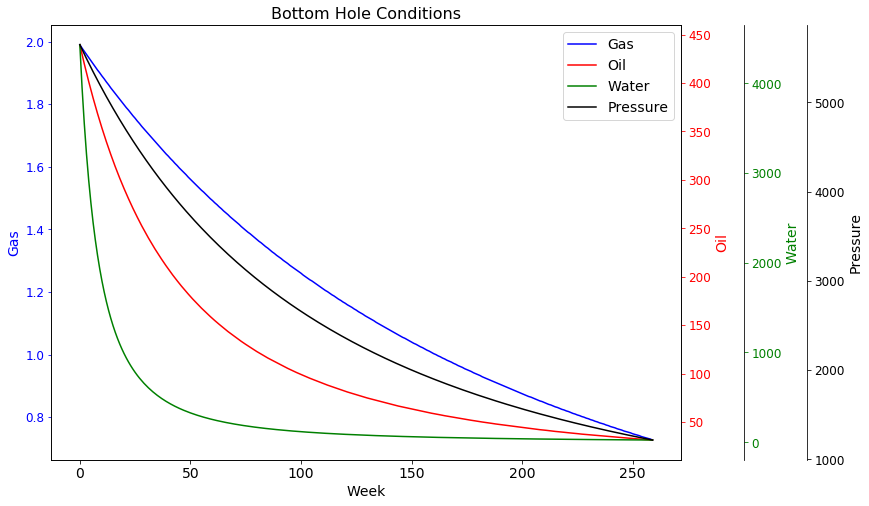

In [41]:
four_y_plot(df['Gas Flow_MMSCFD'], "Gas",
            df['Oil_bpd'], "Oil", 
            df['Water_bpd'],"Water",
            df['FWHP_psig'], "Pressure",
            "Week",
            "Bottom Hole Conditions")

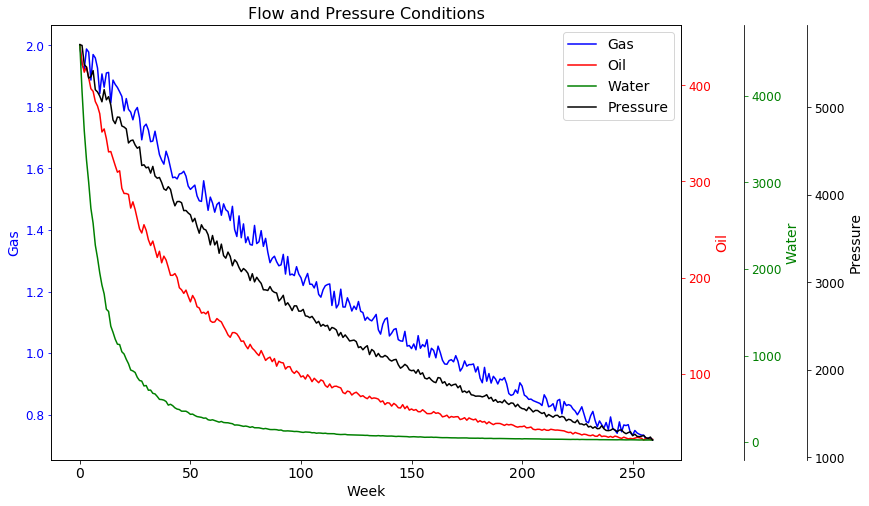

In [42]:
four_y_plot(dfnoise['Gas Flow_MMSCFD'], "Gas",
            dfnoise['Oil_bpd'], "Oil", 
            dfnoise['Water_bpd'],"Water",
            dfnoise['FWHP_psig'], "Pressure",
            "Week",
            "Flow and Pressure Conditions")

Prepare train and test data

In [43]:
X_pre= preprocessing.StandardScaler().fit(X_pre).transform(X_pre)
X_pre[0:5]
X_hol= preprocessing.StandardScaler().fit(X_hol).transform(X_hol)
X_hol[0:5]

array([[ 2.23970334,  3.42406948,  6.58216053,  2.56736951, -0.91667945,
         6.08774454,  5.96778178, -1.1171822 ,  6.10578084, -0.97945762,
        -1.55850943,  1.62196475, -2.1015867 ,  2.1015867 ],
       [ 2.20859484,  3.31882994,  5.82415528,  2.52325256, -0.67955852,
         5.44879228,  5.34489299, -1.1025325 ,  5.46206381, -0.9953094 ,
        -1.55156806,  1.6381069 , -2.1015867 ,  2.1015867 ],
       [ 2.18031439,  3.21674759,  5.18549869,  2.47980915, -0.45787437,
         4.90702618,  4.8188104 , -1.08880367,  4.91641874, -1.01042225,
        -1.54448407,  1.65228878, -2.1015867 ,  2.1015867 ],
       [ 2.15203393,  3.11887482,  4.64205021,  2.43695509, -0.25349493,
         4.44305372,  4.36990303, -1.07608214,  4.44929304, -1.02469809,
        -1.53727698,  1.6645371 , -2.1015867 ,  2.1015867 ],
       [ 2.12375347,  3.02415924,  4.17552442,  2.39469038, -0.06353338,
         4.04215813,  3.98351463, -1.06420598,  4.04579491, -1.03825211,
        -1.52996661,  1.67

In [44]:
X_noisepre= preprocessing.StandardScaler().fit(X_noisepre).transform(X_noisepre)

X_noisehol= preprocessing.StandardScaler().fit(X_noisehol).transform(X_noisehol)

In [45]:
X_train0=X_pre[0:182]
y_train0=y_pre[0:182]
X_test0=X_pre[182:]
y_test0=y_pre[182:]
# hold up data
X_hol_train0=X_hol[0:182]
y_hol_train0=y_hol[0:182]
X_hol_test0=X_hol[182:]
y_hol_test0=y_hol[182:]

In [46]:
X_noisetrain0=X_noisepre[0:182]
y_noisetrain0=y_noisepre[0:182]
X_noisetest0=X_noisepre[182:]
y_noisetest0=y_noisepre[182:]
# hold up data
X_hol_noisetrain0=X_noisehol[0:182]
y_hol_noisetrain0=y_noisehol[0:182]
X_hol_noisetest0=X_noisehol[182:]
y_hol_noisetest0=y_noisehol[182:]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_pre[0:182],y_pre[0:182], test_size=0.05,random_state=21)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
y_test.shape[0]

Train set: (172, 4) (172,)
Test set: (10, 4) (10,)


10

# *SVM*

In [48]:
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection



In [49]:

# Parameters for smooth line input
svr_rbf = svm.SVR(kernel='rbf', C=3000, gamma=0.0019, epsilon=0.1)
svr_lin = svm.SVR(kernel='linear', C=52, gamma=0.1, epsilon=0.1)
svr_poly = svm.SVR(kernel='poly',gamma=1, degree=3, epsilon=.1,
               coef0=2.1)

clf=svr_lin.fit(X_train, y_train)
print(clf.score(X_test0,y_test0))
y_hat=svr_lin.predict(X_test0)

# print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_hat))

-1.2143675027195484


In [50]:
def cross_valuations(svr_, Xdata, ydata, nsplit, s1, l1, s2, l2, s3, l3):
    
    kfold = model_selection.KFold(n_splits=nsplit, random_state=21, shuffle=True)
    
    scores = [s1, s2, s3]
    labels = [l1, l2, l3]
    
    for ix, score in enumerate(scores):
        results = model_selection.cross_val_score(svr_, Xdata, ydata, cv=kfold, scoring=scores[ix])
        print("SVR", svr_.kernel,labels[ix],format(results.mean(),'.4f'), format(results.std(),'.4f'))
    print('\n')   
    
   

Evaluate different algorithms

In [51]:
svrs = [svr_rbf, svr_lin, svr_poly]
for i in range(len(svrs)):
    cross_valuations(svrs[i],
                 X_train0,
                 y_train0,
                 7,
                 "neg_mean_absolute_error", "MAE:",
                 "neg_root_mean_squared_error", "RMSE:",
                 "r2", "R^2:"
                 )


SVR rbf MAE: -53.2329 4.7236
SVR rbf RMSE: -63.9629 5.5175
SVR rbf R^2: 0.9882 0.0035


SVR linear MAE: -29.2879 2.5449
SVR linear RMSE: -43.3215 10.5903
SVR linear R^2: 0.9945 0.0023


SVR poly MAE: -6.2728 1.7281
SVR poly RMSE: -7.8458 1.9056
SVR poly R^2: 0.9998 0.0001




In [52]:
def three_svr_plot(svr1, label1, svr2, label2, svr3, label3, trainx, trainy, testx, testy, labelx, labely, ftitle):
    # Look at the results
    lw = 2
    
    svrs = [svr1, svr2, svr3]
    kernel_label = [label1, label2, label3]
    model_color = ['b', 'c', 'g']
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 12), sharey=True)
    for ix, svr in enumerate(svrs):
        y_hat=svr.fit(trainx, trainy).predict(testx)
        
        MAE=format(metrics.mean_absolute_error(testy, y_hat),'.3f')
        MSE=format(metrics.mean_squared_error(testy, y_hat),'.2f')
        R2=format(metrics.r2_score(testy, y_hat),'.4f')        
        
        axes[ix].plot(y_hat, color=model_color[ix], lw=lw,
                      label='{} (MAE: {},  R^2: {})'.format(kernel_label[ix], MAE, R2))
        axes[ix].plot(testy.reset_index(drop=True), color='red', linestyle=':', lw=3,
                      label='Test data')                    
        axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                        ncol=1, fancybox=False, shadow=False, fontsize=14)
    fig.text(0.5, 0.04, labelx, ha='center', va='center', fontsize=12)
    fig.text(0.06, 0.5, labely, ha='center', va='center', rotation='vertical', fontsize=12)
    fig.suptitle(ftitle, fontsize=16)
    plt.show()

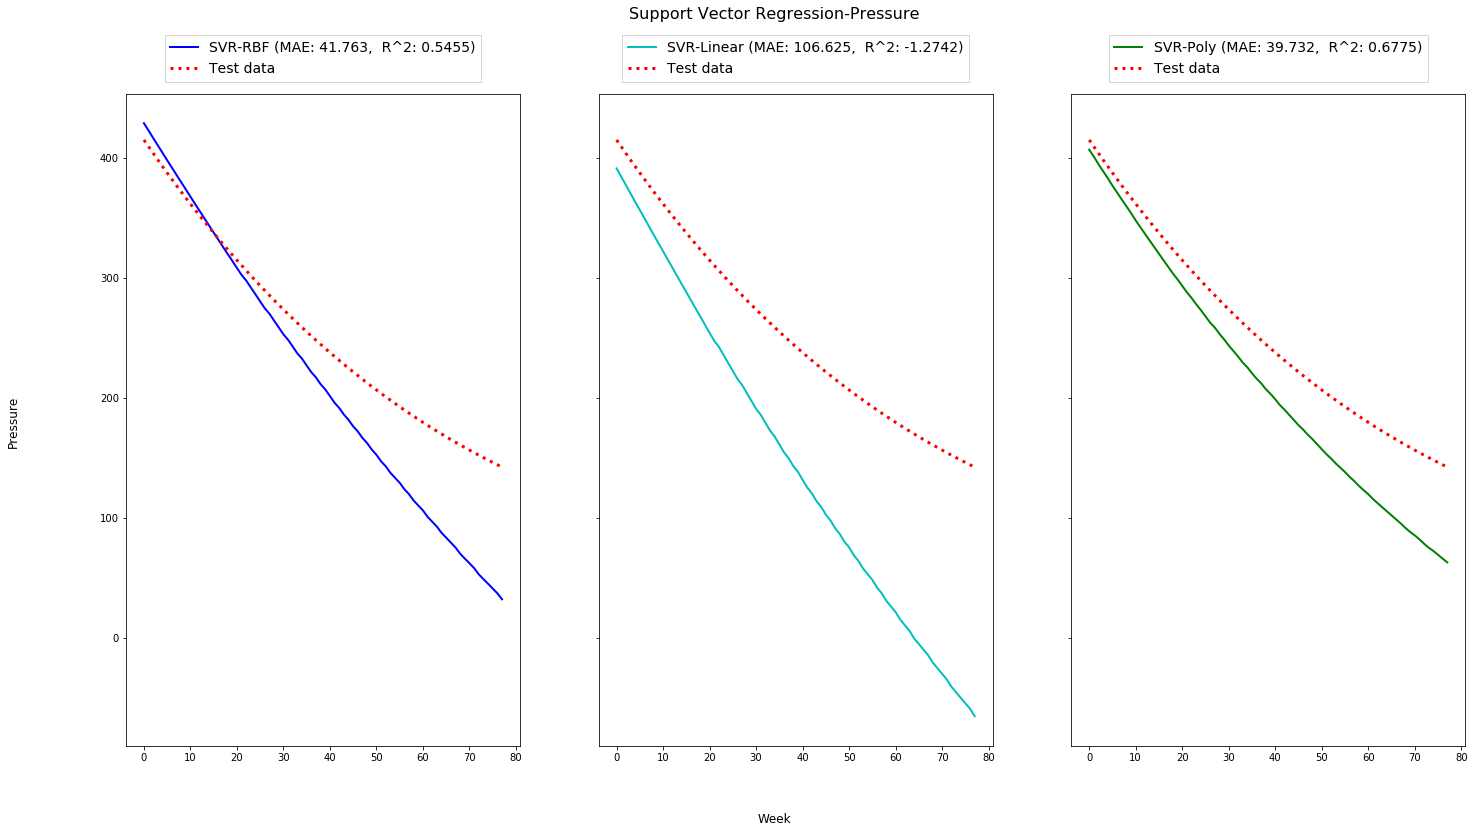

In [53]:
three_svr_plot(svr_rbf, "SVR-RBF",
               svr_lin, "SVR-Linear",
               svr_poly, "SVR-Poly",
               X_train0,
               y_train0,
               X_test0,
               y_test0,
               "Week",
               "Pressure",
               "Support Vector Regression-Pressure")

In [108]:
# Paramters for noise input
svr_rbf = svm.SVR(kernel='rbf', C=3000, gamma=0.003, epsilon=0.1)
svr_lin = svm.SVR(kernel='linear', C=150, gamma=0.1, epsilon=0.1)
svr_poly = svm.SVR(kernel='poly',gamma=0.2, degree=4, epsilon=0.1,
               coef0=5)



In [55]:
svrs = [svr_rbf, svr_lin, svr_poly]
for i in range(len(svrs)):
    cross_valuations(svrs[i],
                 X_train0,
                 y_train0,
                 7,
                 "neg_mean_absolute_error", "MAE:",
                 "neg_root_mean_squared_error", "RMSE:",
                 "r2", "R^2:"
                 )


SVR rbf MAE: -18.4736 1.8182
SVR rbf RMSE: -22.3380 1.3693
SVR rbf R^2: 0.9985 0.0005


SVR linear MAE: -22.2479 1.5337
SVR linear RMSE: -29.3070 6.3079
SVR linear R^2: 0.9975 0.0009


SVR poly MAE: -6.6451 1.2982
SVR poly RMSE: -8.0118 1.5229
SVR poly R^2: 0.9998 0.0001




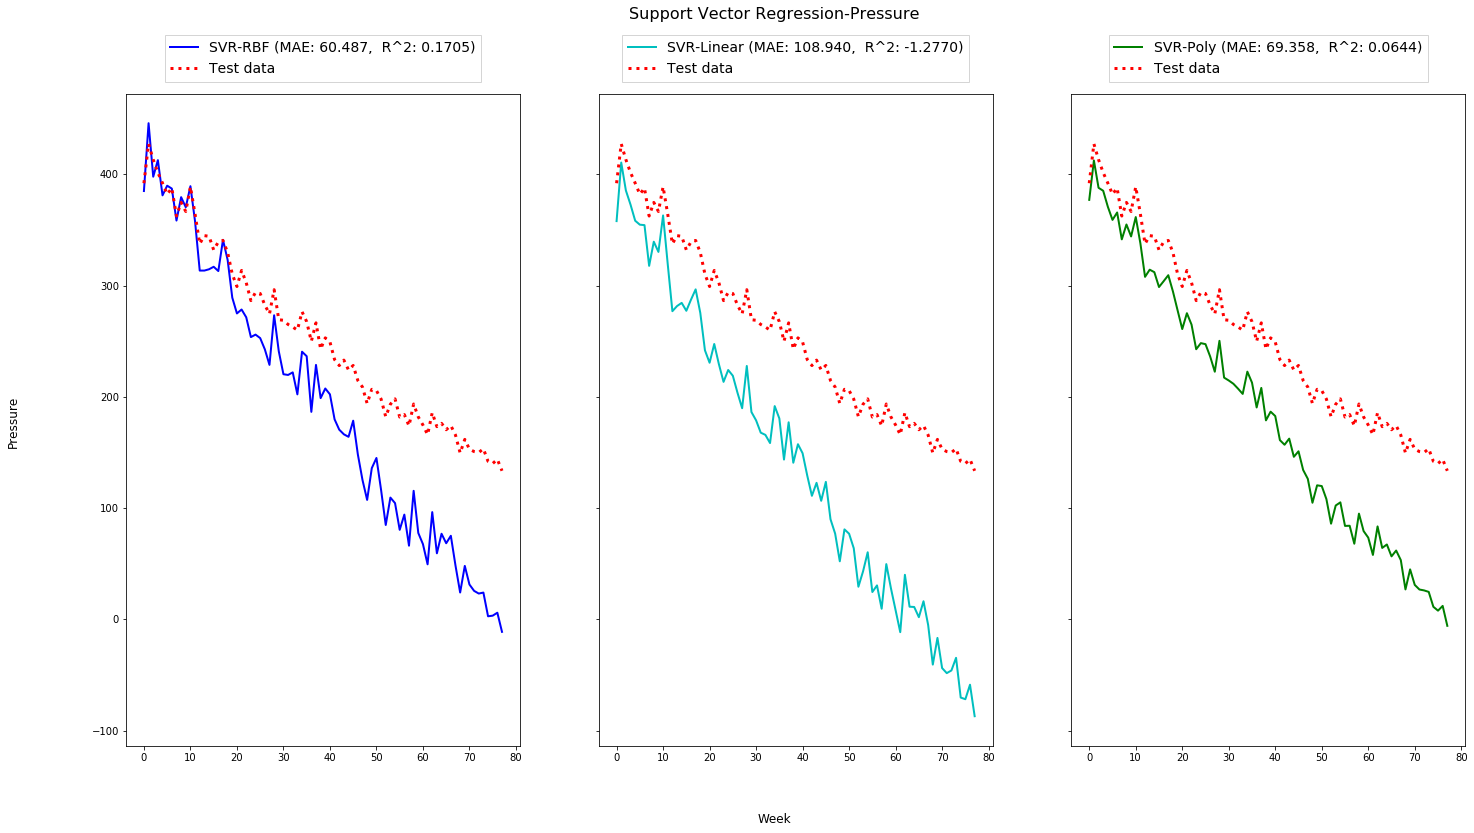

In [109]:
three_svr_plot(svr_rbf, "SVR-RBF",
               svr_lin, "SVR-Linear",
               svr_poly, "SVR-Poly",
               X_noisetrain0,
               y_noisetrain0,
               X_noisetest0,
               y_noisetest0,
               "Week",
               "Pressure",
               "Support Vector Regression-Pressure")

Predict Holdup

In [57]:
hol_svr_rbf = svm.SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.0001)
hol_svr_lin = svm.SVR(kernel='linear', C=0.2, gamma=0.005, epsilon=0.0001)
hol_svr_poly = svm.SVR(kernel='poly',gamma=0.01, degree=3, epsilon=.0001,
               coef0=0.6)

svrs = [hol_svr_rbf, hol_svr_lin, hol_svr_poly]
for i in range(len(svrs)):
    cross_valuations(svrs[i],
                 X_hol_train0,
                 y_hol_train0,
                 10,
                 "neg_mean_absolute_error", "MAE:",
                 "neg_root_mean_squared_error", "RMSE:",
                 "r2", "R^2:"
                 )


SVR rbf MAE: -0.0029 0.0011
SVR rbf RMSE: -0.0059 0.0022
SVR rbf R^2: 0.9936 0.0111


SVR linear MAE: -0.0021 0.0007
SVR linearRMSE: -0.0041 0.0017
SVRlinear R^2: 0.9965 0.0067


SVR poly MAE: -0.0003 0.0001
SVR poly RMSE: -0.0005 0.0002
SVR poly R^2: 1.0000 0.0001




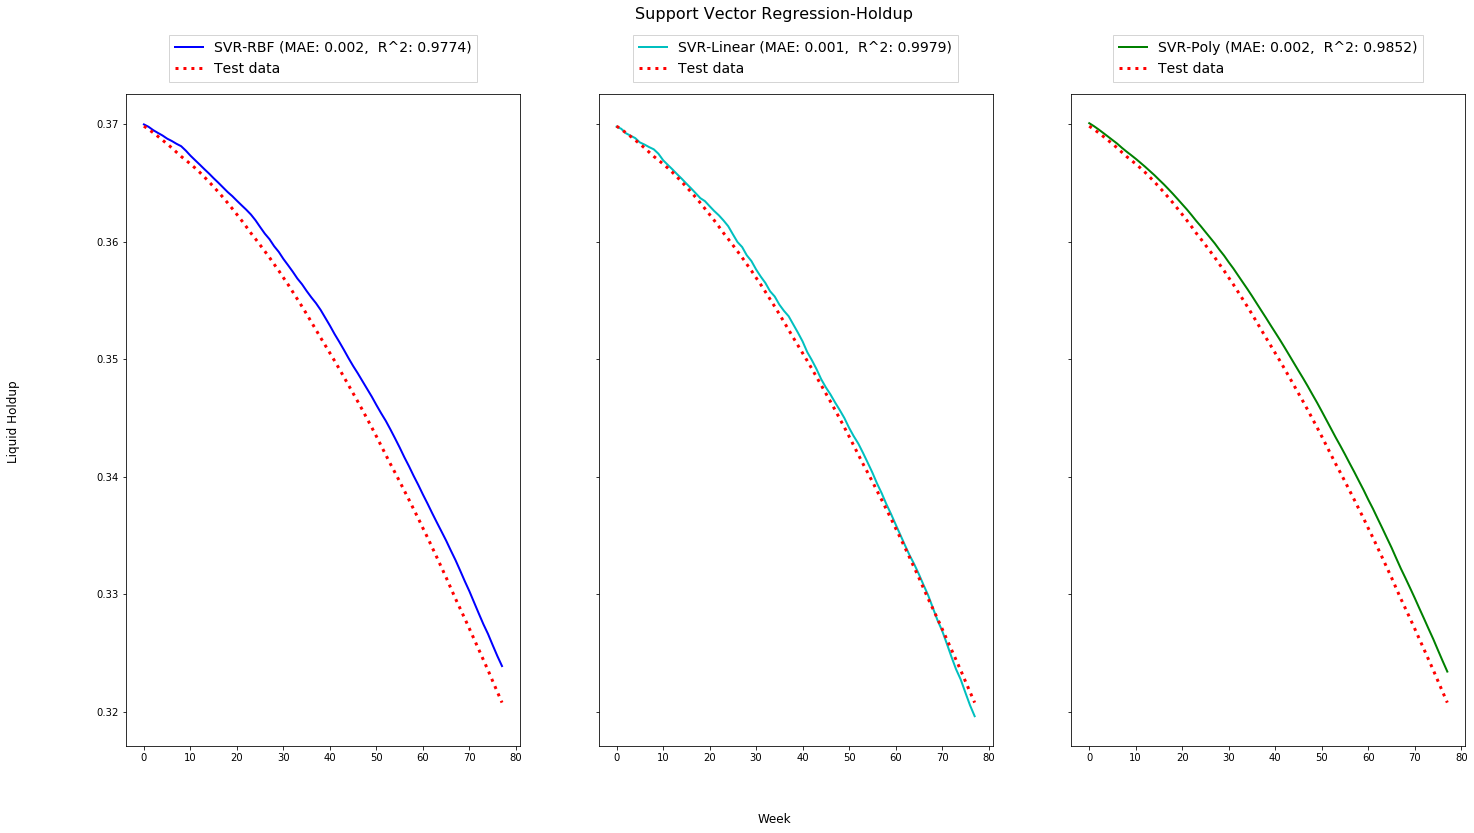

In [58]:
three_svr_plot(hol_svr_rbf, "SVR-RBF",
               hol_svr_lin, "SVR-Linear",
               hol_svr_poly, "SVR-Poly",
               X_hol_train0,
               y_hol_train0,
               X_hol_test0,
               y_hol_test0,
               "Week",
               "Liquid Holdup",
               "Support Vector Regression-Holdup")

In [59]:
hol_svr_rbf = svm.SVR(kernel='rbf', C=90, gamma=0.001, epsilon=0.0001)
hol_svr_lin = svm.SVR(kernel='linear', C=0.8, gamma=0.004, epsilon=0.0001)
hol_svr_poly = svm.SVR(kernel='poly',gamma=0.01, degree=4, epsilon=.00001,
               coef0=0.6)

svrs = [hol_svr_rbf, hol_svr_lin, hol_svr_poly]
for i in range(len(svrs)):
    cross_valuations(svrs[i],
                 X_hol_noisetrain0,
                 y_hol_noisetrain0,
                 10,
                 "neg_mean_absolute_error", "MAE:",
                 "neg_root_mean_squared_error", "RMSE:",
                 "r2", "R^2:"
                 )


SVR rbf MAE: -0.0015 0.0004
SVR rbf RMSE: -0.0028 0.0009
SVR rbf R^2: 0.9988 0.0019


SVR linear MAE: -0.0017 0.0005
SVR linear RMSE: -0.0029 0.0008
SVR linear R^2: 0.9988 0.0016


SVR poly MAE: -0.0018 0.0004
SVR poly RMSE: -0.0033 0.0010
SVR poly R^2: 0.9983 0.0028




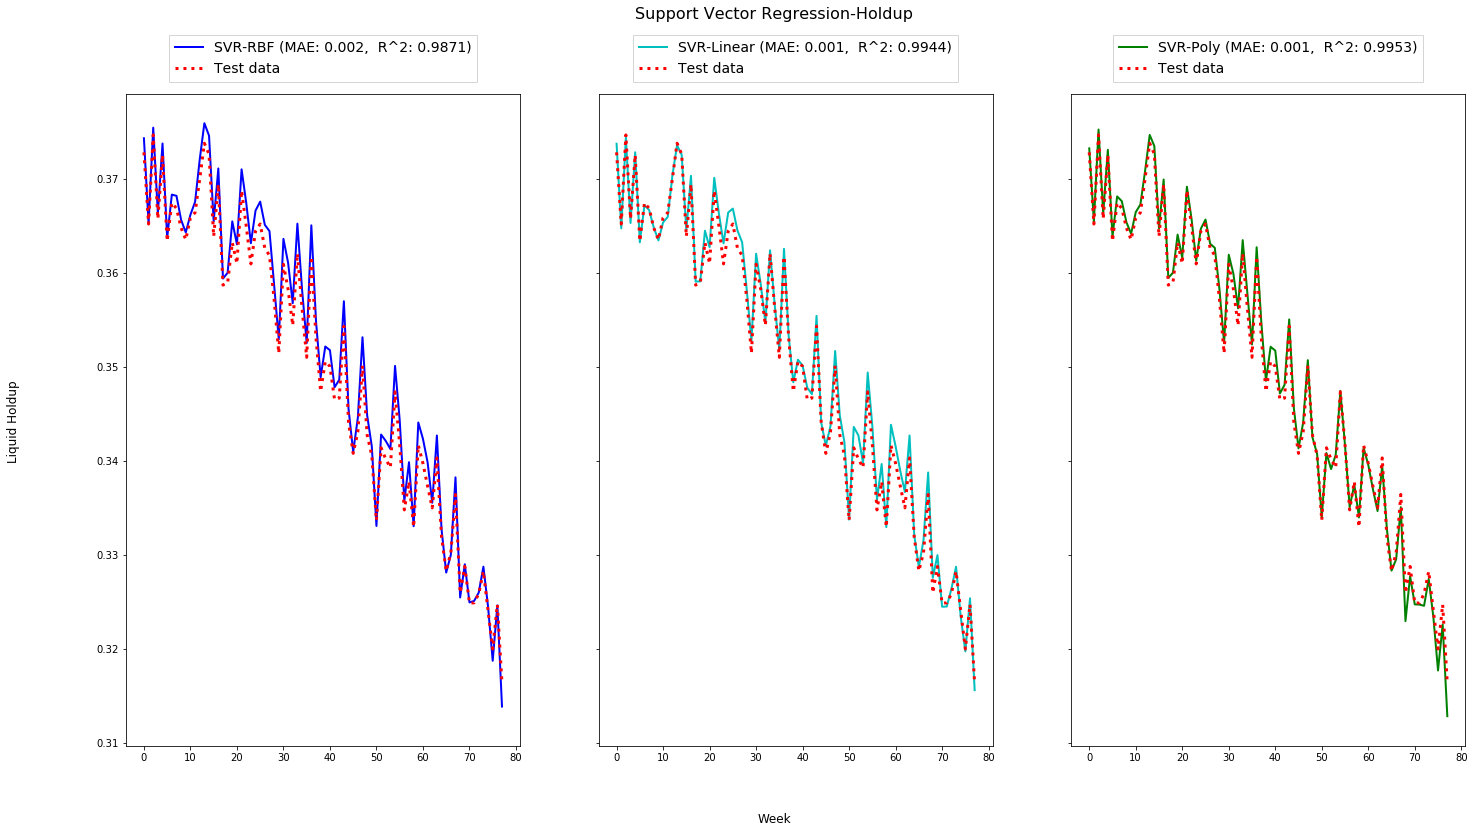

In [60]:
three_svr_plot(hol_svr_rbf, "SVR-RBF",
               hol_svr_lin, "SVR-Linear",
               hol_svr_poly, "SVR-Poly",
               X_hol_noisetrain0,
               y_hol_noisetrain0,
               X_hol_noisetest0,
               y_hol_noisetest0,
               "Week",
               "Liquid Holdup",
               "Support Vector Regression-Holdup")

# Gradient Boost

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

X_train=X_noisetrain0
y_train=y_noisetrain0

X_test=X_noisetest0
y_test=y_noisetest0

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbrt= GradientBoostingRegressor(**params)


kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(gbrt, X_train, y_train, cv=kfold)
print("Cross Val Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


gbrt.fit(X_noisetrain0, y_noisetrain0)
y_pred = gbrt.predict(X_noisetest0)

MAE=format(metrics.mean_absolute_error(y_noisetest0, y_pred),'.3f')
MSE=format(metrics.mean_squared_error(y_noisetest0, y_pred),'.2f')
R2=format(metrics.r2_score(y_noisetest0, y_pred),'.4f')       

lin_mse = mean_squared_error(y_pred, y_noisetest0)
lin_rmse = np.sqrt(lin_mse)
print('RMSE: %.4f' % lin_rmse)
print('MAE:', MAE)
print('MSE:', MSE)
print('R2:',  R2)


Cross Val Accuracy: 99.73% (0.15%)
RMSE: 181.8176
MAE: 163.282
MSE: 33057.65
R2: -4.0592


## Define comparion plot

In [62]:
def comp_plot(ml1, label1, trainx, trainy, testx, testy, labelx, labely, ftitle):
    # Look at the results
    lw = 2
    
    fig= plt.figure(figsize=(12, 10))
   
    y_hat=ml1.fit(trainx, trainy).predict(testx)
        
    MAE=format(metrics.mean_absolute_error(testy, y_hat),'.3f')
    MSE=format(metrics.mean_squared_error(testy, y_hat),'.2f')
    R2=format(metrics.r2_score(testy, y_hat),'.4f')        
        
    plt.plot(y_hat, color='blue', lw=lw,
                      label='{} (MAE: {},  R^2: {})'.format(label1, MAE, R2))
    plt.plot(testy.reset_index(drop=True), color='red', linestyle=':', lw=3,
                      label='Test data')                    
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),fontsize=12)
    plt.xlabel(labelx, fontsize=12)
    plt.ylabel(labely, fontsize=12)
    fig.suptitle(ftitle, fontsize=16)
    plt.show()

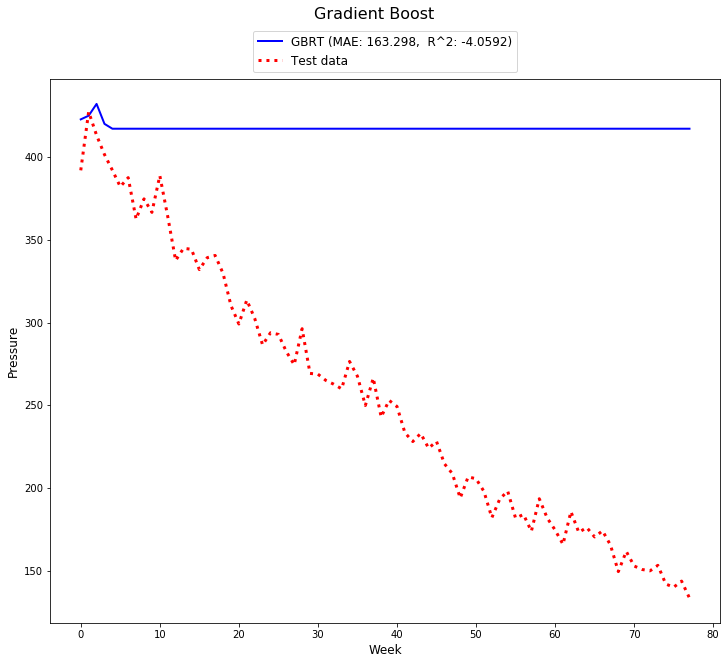

In [63]:
comp_plot(gbrt, "GBRT",
          X_train,
          y_train,
          X_test,
          y_test,
          "Week",
          "Pressure",
          "Gradient Boost")

# Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor

In [65]:
params = {'n_estimators': 500, 'max_depth': 30, 'random_state': 0,}

RFR = RandomForestRegressor(**params)

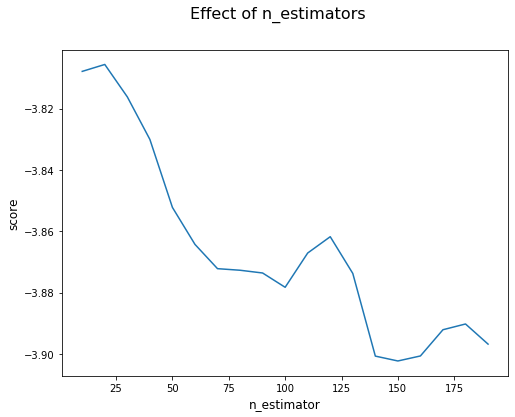

In [66]:
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    RFR.set_params(n_estimators=n)
    RFR.fit(X_train, y_train)
    scores.append(RFR.score(X_test, y_test))
fig= plt.figure(figsize=(8, 6))
plt.xlabel("n_estimator",fontsize=12)
plt.ylabel("score",fontsize=12)
fig.suptitle("Effect of n_estimators", fontsize=16)
plt.plot(estimators, scores)
plt.show()

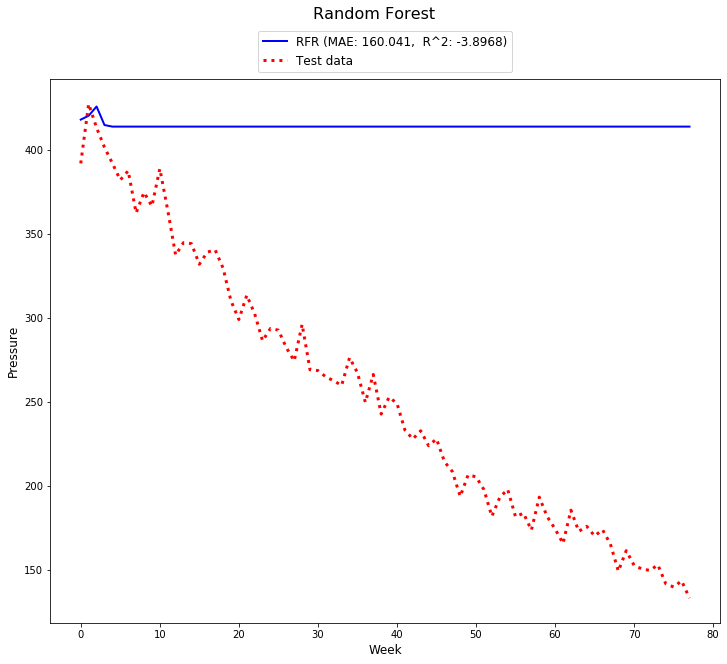

In [67]:
comp_plot(RFR, "RFR",
          X_train,
          y_train,
          X_test,
          y_test,
          "Week",
          "Pressure",
          "Random Forest")

# XGBoost

In [68]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

In [69]:
params={'colsample_bytree': 0.7587948587257435, 'gamma': 0.022613644455269033, 'learning_rate': 0.1275990992289793, 'max_depth': 5, 'n_estimators': 144, 'subsample': 0.7085396127095583}

xgbr = xgb.XGBRegressor(**params)

xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

MAE=format(metrics.mean_absolute_error(y_test, y_pred),'.3f')
MSE=format(metrics.mean_squared_error(y_test, y_pred),'.2f')
R2=format(metrics.r2_score(y_test, y_pred),'.4f')       

lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('RMSE: %.4f' % lin_rmse)
print('MAE:', MAE)
print('MSE:', MSE)
print('R2:',  R2)

C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
[10:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 174.1485
MAE: 154.794
MSE: 30327.70
R2: -3.6414


[10:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


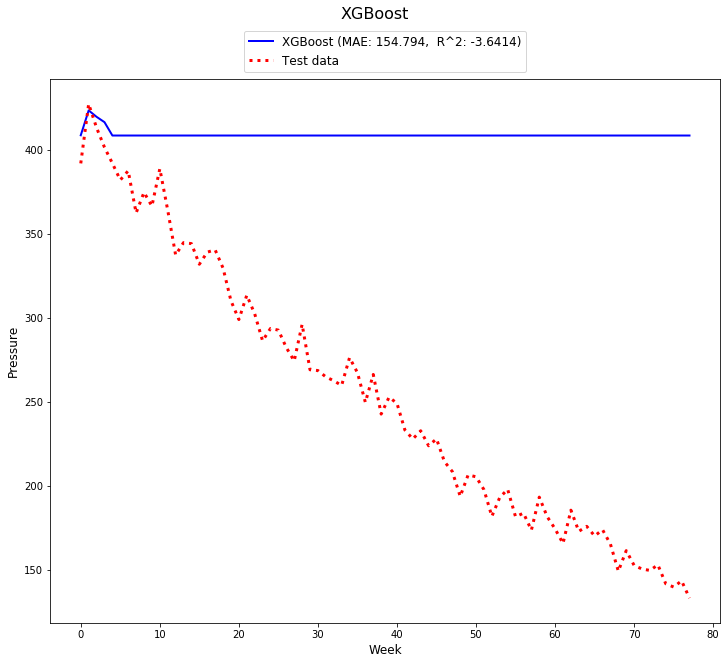

In [70]:
comp_plot(xgbr, "XGBoost",
          X_train,
          y_train,
          X_test,
          y_test,
          "Week",
          "Pressure",
          "XGBoost")

In [71]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [72]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [73]:
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)
mse=mean_squared_error(y_test, y_pred)

print(np.sqrt(mse))

[10:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
174.14849213627792
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Hyperparameter tuning

In [74]:
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

ang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
[10:28:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
C:\Users\xuesong.wang1\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not No

Evaluation